<a href="https://colab.research.google.com/github/shishir-sh26/port/blob/main/LSTM_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Path to your MFCC features in Google Drive
DRIVE_DATA_DIR = "/content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc"

# Destination path in Colab's local storage
COLAB_LOCAL_DATA_DIR = "/content/mfcc"

# ✅ Check if source exists before copying
if not os.path.exists(DRIVE_DATA_DIR):
    raise FileNotFoundError(f"Source folder not found: {DRIVE_DATA_DIR}")

# Remove old copy if it exists
if os.path.exists(COLAB_LOCAL_DATA_DIR):
    shutil.rmtree(COLAB_LOCAL_DATA_DIR)

# Copy entire folder from Drive to local
shutil.copytree(DRIVE_DATA_DIR, COLAB_LOCAL_DATA_DIR)

print(f"✅ Copied MFCC folder to local storage.")
print(f"From: {DRIVE_DATA_DIR}")
print(f"To:   {COLAB_LOCAL_DATA_DIR}")


✅ Copied MFCC folder to local storage.
From: /content/drive/MyDrive/AvianWeatherNet/extracted_features/mfcc
To:   /content/mfcc


In [ ]:
# === Step 1: Mount Google Drive & set up paths ===

# 1) Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) (Optional) Verify GPU availability
import tensorflow as tf
gpu_available = tf.config.list_physical_devices('GPU')
print("GPU available:", bool(gpu_available), gpu_available)

# 3) ---- PATHS ----
COLAB_LOCAL_DATA_DIR = "/content/mfcc"  # Your local MFCC features folder
DATA_DIR = COLAB_LOCAL_DATA_DIR         # We’ll load from here in Step 2

# Output directory for artifacts on Drive
OUTPUT_DIR = "/content/drive/MyDrive/AvianWeatherNet/srinivas/LSTM"
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 4) Save metadata for reproducibility
import json, sys, platform, time
meta = {
    "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
    "python_version": sys.version,
    "platform": platform.platform(),
    "tensorflow_version": tf.__version__,
    "data_dir": DATA_DIR,
    "output_dir": OUTPUT_DIR,
    "gpu_available": bool(gpu_available),
}
with open(os.path.join(OUTPUT_DIR, "run_meta_step1.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("\n✅ Step 1 complete.")
print("DATA_DIR    ->", DATA_DIR)
print("OUTPUT_DIR  ->", OUTPUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPU available: True [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Step 1 complete.
DATA_DIR    -> /content/mfcc
OUTPUT_DIR  -> /content/drive/MyDrive/AvianWeatherNet/srinivas/LSTM


In [ ]:
import os

print("Listing contents of:", DATA_DIR)
if not os.path.exists(DATA_DIR):
    print("❌ Path does not exist.")
else:
    files = os.listdir(DATA_DIR)
    print(f"Found {len(files)} items:")
    for f in files:
        print("  ", f)


Listing contents of: /content/mfcc
Found 5 items:
   Cloudy
   Rainy
   Windy
   Foggy
   Sunny


In [ ]:
# === Step 2: Load MFCC features (transpose + pad) from subfolders ===
import os
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

features = []
labels = []

# List label folders
label_folders = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])

# Count total files
total_files = sum(
    len([f for f in os.listdir(os.path.join(DATA_DIR, lbl)) if f.endswith('.npy') or f.endswith('.npz')])
    for lbl in label_folders
)
print(f"Found {total_files} MFCC files across {len(label_folders)} classes: {label_folders}")

loaded_count = 0

for label_name in label_folders:
    label_dir = os.path.join(DATA_DIR, label_name)
    files = [f for f in os.listdir(label_dir) if f.endswith('.npy') or f.endswith('.npz')]

    for file_name in files:
        file_path = os.path.join(label_dir, file_name)

        # Load MFCC
        if file_name.endswith('.npy'):
            data = np.load(file_path, allow_pickle=True)
        elif file_name.endswith('.npz'):
            data = np.load(file_path)
            data = data["arr_0"] if "arr_0" in data else list(data.values())[0]

        # Ensure shape is (time_steps, n_features)
        if data.shape[0] < data.shape[1]:  # if shape like (13, time)
            data = data.T

        features.append(data)
        labels.append(label_name)

        loaded_count += 1
        if loaded_count % 500 == 0 or loaded_count == total_files:
            percent = (loaded_count / total_files) * 100
            print(f"Loaded {loaded_count}/{total_files} files ({percent:.2f}%)")

# Get max time length
max_timesteps = max(f.shape[0] for f in features)
n_features = features[0].shape[1]
print(f"Padding sequences to max length: {max_timesteps}, feature size: {n_features}")

# Pad along time dimension only
features_padded = pad_sequences(
    features, maxlen=max_timesteps, dtype='float32', padding='post', truncating='post'
)

features = np.array(features_padded, dtype='float32')
labels = np.array(labels)

print(f"\n✅ Step 2 complete: Loaded {features.shape[0]} samples")
print(f"Final padded feature shape: {features.shape}")
print("Unique labels:", np.unique(labels))


Found 60030 MFCC files across 5 classes: ['Cloudy', 'Foggy', 'Rainy', 'Sunny', 'Windy']
Loaded 500/60030 files (0.83%)
Loaded 1000/60030 files (1.67%)
Loaded 1500/60030 files (2.50%)
Loaded 2000/60030 files (3.33%)
Loaded 2500/60030 files (4.16%)
Loaded 3000/60030 files (5.00%)
Loaded 3500/60030 files (5.83%)
Loaded 4000/60030 files (6.66%)
Loaded 4500/60030 files (7.50%)
Loaded 5000/60030 files (8.33%)
Loaded 5500/60030 files (9.16%)
Loaded 6000/60030 files (10.00%)
Loaded 6500/60030 files (10.83%)
Loaded 7000/60030 files (11.66%)
Loaded 7500/60030 files (12.49%)
Loaded 8000/60030 files (13.33%)
Loaded 8500/60030 files (14.16%)
Loaded 9000/60030 files (14.99%)
Loaded 9500/60030 files (15.83%)
Loaded 10000/60030 files (16.66%)
Loaded 10500/60030 files (17.49%)
Loaded 11000/60030 files (18.32%)
Loaded 11500/60030 files (19.16%)
Loaded 12000/60030 files (19.99%)
Loaded 12500/60030 files (20.82%)
Loaded 13000/60030 files (21.66%)
Loaded 13500/60030 files (22.49%)
Loaded 14000/60030 files 

In [ ]:
import os
import numpy as np
from tqdm import tqdm

DATA_DIR = "/content/mfcc"
features = []
labels = []

# Load all files from subfolders
for label_name in sorted(os.listdir(DATA_DIR)):
    label_folder = os.path.join(DATA_DIR, label_name)
    if not os.path.isdir(label_folder):
        continue
    for file_name in tqdm(os.listdir(label_folder), desc=f"Loading {label_name}"):
        file_path = os.path.join(label_folder, file_name)
        if file_name.endswith('.npy'):
            mfcc = np.load(file_path)
            features.append(mfcc)
            labels.append(label_name)

print(f"Loaded {len(features)} files from {len(set(labels))} classes")


Loading Windy: 100%|██████████| 12003/12003 [00:07<00:00, 1556.25it/s]

Loaded 60030 files from 5 classes


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Decide max timesteps (adjust as needed)
MAX_TIMESTEPS = 300
n_features = features[0].shape[0]  # MFCC coefficient count (should be 13)

print(f"Padding sequences to max length: {MAX_TIMESTEPS}, feature size: {n_features}")

# Pad along time axis
features_padded = pad_sequences(
    [f.T for f in features],  # transpose to (timesteps, features)
    maxlen=MAX_TIMESTEPS,
    dtype='float32',
    padding='post',
    truncating='post'
)

print(f"Padded shape: {features_padded.shape}")  # (num_samples, MAX_TIMESTEPS, n_features)


Padding sequences to max length: 300, feature size: 13
Padded shape: (60030, 300, 13)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Encode labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)

# Convert to numpy array
y_encoded = np.array(y_encoded)

# Train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    features_padded, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Classes:", label_encoder.classes_)


Train shape: (48024, 300, 13), Test shape: (12006, 300, 13)
Classes: ['Cloudy' 'Foggy' 'Rainy' 'Sunny' 'Windy']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

n_classes = len(np.unique(y_encoded))

model = Sequential([
    LSTM(128, input_shape=(300, 13), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 81,285 (317.52 KB)

 Trainable params: 81,285 (317.52 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Callbacks
checkpoint = ModelCheckpoint(
    "best_lstm_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=14,
    batch_size=64,
    callbacks=[checkpoint, early_stop],
    verbose=1
)


Epoch 1/14
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4924 - loss: 1.1905
Epoch 1: val_accuracy improved from -inf to 0.51216, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4924 - loss: 1.1905 - val_accuracy: 0.5122 - val_loss: 1.1480
Epoch 2/14
748/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4977 - loss: 1.1735
Epoch 2: val_accuracy improved from 0.51216 to 0.52157, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.4977 - loss: 1.1735 - val_accuracy: 0.5216 - val_loss: 1.1271
Epoch 3/14
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5045 - loss: 1.1612
Epoch 3: val_accuracy improved from 0.52157 to 0.52307, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5045 - loss: 1.1612 - val_accuracy: 0.5231 - val_loss: 1.1254
Epoch 4/14
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5049 - loss: 1.1575
Epoch 4: val_accuracy improved from 0.52307 to 0.52807, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5049 - loss: 1.1575 - val_accuracy: 0.5281 - val_loss: 1.1150
Epoch 5/14
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5120 - loss: 1.1430
Epoch 5: val_accuracy improved from 0.52807 to 0.53823, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5120 - loss: 1.1430 - val_accuracy: 0.5382 - val_loss: 1.1003
Epoch 6/14
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5160 - loss: 1.1389
Epoch 6: val_accuracy improved from 0.53823 to 0.53998, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.5160 - loss: 1.1389 - val_accuracy: 0.5400 - val_loss: 1.0798
Epoch 7/14
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5245 - loss: 1.1141
Epoch 7: val_accuracy improved from 0.53998 to 0.54664, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5245 - loss: 1.1141 - val_accuracy: 0.5466 - val_loss: 1.0792
Epoch 8/14
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5170 - loss: 1.1192
Epoch 8: val_accuracy did not improve from 0.54664
751/751 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5170 - loss: 1.1192 - val_accuracy: 0.5409 - val_loss: 1.0792
Epoch 9/14
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5299 - loss: 1.0963
Epoch 9: val_accuracy improved from 0.54664 to 0.55006, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.5299 - loss: 1.0963 - val_accuracy: 0.5501 - val_loss: 1.0639
Epoch 10/14
749/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5319 - loss: 1.0942
Epoch 10: val_accuracy improved from 0.55006 to 0.55356, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - accuracy: 0.5319 - loss: 1.0942 - val_accuracy: 0.5536 - val_loss: 1.0585
Epoch 11/14
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5358 - loss: 1.0903
Epoch 11: val_accuracy did not improve from 0.55356
751/751 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5358 - loss: 1.0903 - val_accuracy: 0.5465 - val_loss: 1.0626
Epoch 12/14
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5370 - loss: 1.0835
Epoch 12: val_accuracy improved from 0.55356 to 0.55464, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - accuracy: 0.5370 - loss: 1.0835 - val_accuracy: 0.5546 - val_loss: 1.0541
Epoch 13/14
750/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5396 - loss: 1.0784
Epoch 13: val_accuracy did not improve from 0.55464
751/751 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.5396 - loss: 1.0784 - val_accuracy: 0.5532 - val_loss: 1.0547
Epoch 14/14
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5408 - loss: 1.0682
Epoch 14: val_accuracy improved from 0.55464 to 0.56455, saving model to best_lstm_model.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.5408 - loss: 1.0682 - val_accuracy: 0.5646 - val_loss: 1.0358
Restoring model weights from the end of the best epoch: 14.


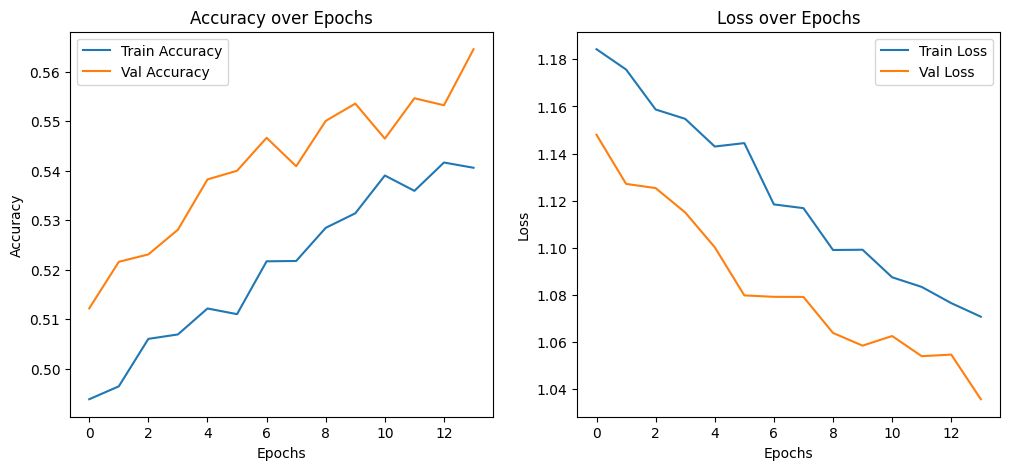

376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step

Classification Report:
               precision    recall  f1-score   support

      Cloudy       0.45      0.47      0.46      2406
       Foggy       0.70      0.77      0.74      2400
       Rainy       0.58      0.31      0.40      2400
       Sunny       0.60      0.53      0.56      2399
       Windy       0.52      0.74      0.61      2401

    accuracy                           0.56     12006
   macro avg       0.57      0.56      0.55     12006
weighted avg       0.57      0.56      0.55     12006



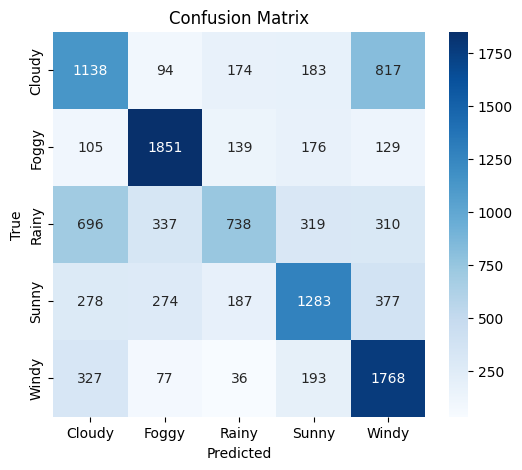

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- Plot Training & Validation Accuracy ---
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# --- Plot Training & Validation Loss ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.show()

# --- Evaluate Model ---
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # predicted labels
y_true = y_test                             # true labels (already integers)

print("\nClassification Report:\n", classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]))),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])

bi_lstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint("best_bilstm_model.h5", monitor='val_accuracy', save_best_only=True, verbose=0)
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train (smaller batch for speed, fewer epochs)
history = bi_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=128,
    callbacks=[checkpoint, early_stop],
    verbose=1
)

# Save
bi_lstm_model.save("final_bilstm_model.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2618 - loss: 1.5967

376/376 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy: 0.2620 - loss: 1.5965 - val_accuracy: 0.3641 - val_loss: 1.4436
Epoch 2/15
374/376 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3458 - loss: 1.4586

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.3459 - loss: 1.4585 - val_accuracy: 0.4162 - val_loss: 1.3552
Epoch 3/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3832 - loss: 1.4010

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.3833 - loss: 1.4009 - val_accuracy: 0.4468 - val_loss: 1.2983
Epoch 4/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4110 - loss: 1.3532

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.4110 - loss: 1.3532 - val_accuracy: 0.4709 - val_loss: 1.2642
Epoch 5/15
374/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4292 - loss: 1.3268

376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4292 - loss: 1.3267 - val_accuracy: 0.4848 - val_loss: 1.2326
Epoch 6/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4468 - loss: 1.2917

376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4468 - loss: 1.2916 - val_accuracy: 0.4912 - val_loss: 1.2005
Epoch 7/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4588 - loss: 1.2739

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4588 - loss: 1.2739 - val_accuracy: 0.5076 - val_loss: 1.1832
Epoch 8/15
374/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4667 - loss: 1.2515

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.4667 - loss: 1.2515 - val_accuracy: 0.5142 - val_loss: 1.1571
Epoch 9/15
374/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4726 - loss: 1.2345

376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4726 - loss: 1.2344 - val_accuracy: 0.5226 - val_loss: 1.1473
Epoch 10/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4847 - loss: 1.2118

376/376 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.4847 - loss: 1.2118 - val_accuracy: 0.5271 - val_loss: 1.1272
Epoch 11/15
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4852 - loss: 1.2049

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4852 - loss: 1.2049 - val_accuracy: 0.5340 - val_loss: 1.1129
Epoch 12/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4933 - loss: 1.1878

376/376 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.4933 - loss: 1.1878 - val_accuracy: 0.5366 - val_loss: 1.1048
Epoch 13/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5006 - loss: 1.1700

376/376 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.5006 - loss: 1.1700 - val_accuracy: 0.5368 - val_loss: 1.0964
Epoch 14/15
375/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5123 - loss: 1.1600

376/376 ━━━━━━━━━━━━━━━━━━━━ 20s 27ms/step - accuracy: 0.5122 - loss: 1.1600 - val_accuracy: 0.5413 - val_loss: 1.0901
Epoch 15/15
374/376 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5108 - loss: 1.1489

376/376 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.5107 - loss: 1.1489 - val_accuracy: 0.5487 - val_loss: 1.0729


In [ ]:
from tensorflow.keras.models import load_model
best_bilstm = load_model("best_bilstm_model.h5")


376/376 ━━━━━━━━━━━━━━━━━━━━ 62s 9ms/step

Classification Report:

              precision    recall  f1-score   support

      Cloudy       0.43      0.39      0.41      2406
       Foggy       0.74      0.72      0.73      2400
       Rainy       0.51      0.36      0.42      2400
       Sunny       0.60      0.53      0.56      2399
       Windy       0.49      0.74      0.59      2401

    accuracy                           0.55     12006
   macro avg       0.55      0.55      0.54     12006
weighted avg       0.55      0.55      0.54     12006



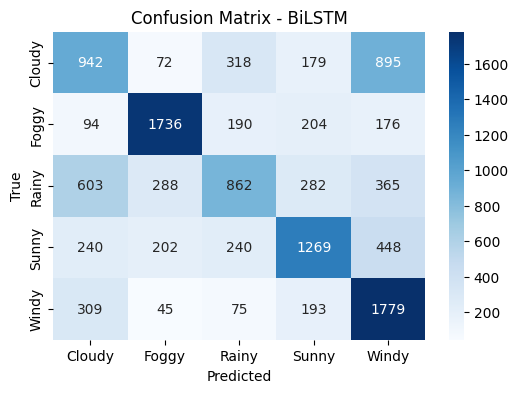

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions
y_pred = best_bilstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Metrics
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BiLSTM")
plt.show()


In [ ]:
import json
import pickle

# Save classification report as JSON
report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)
with open("bilstm_classification_report.json", "w") as f:
    json.dump(report, f, indent=4)

# Save confusion matrix
np.save("bilstm_confusion_matrix.npy", cm)

# Save training history
with open("bilstm_training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Save final model
best_bilstm.save("bilstm_model_final.h5")


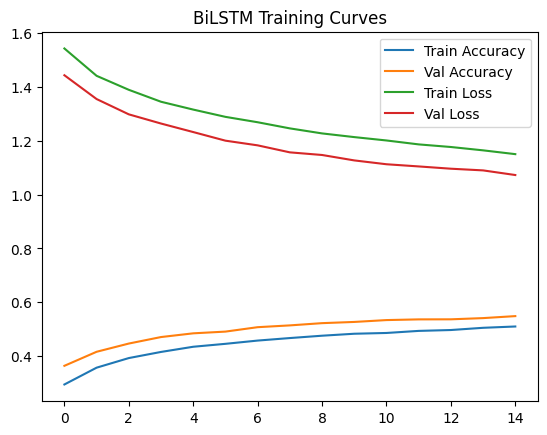

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("BiLSTM Training Curves")
plt.show()


# Task
Generate AUC-ROC graphs for both the LSTM and BiLSTM models using their predictions on the test set.

## Get model predictions

### Subtask:
Get the predicted probabilities for each class on the test set for both the LSTM and BiLSTM models.


**Reasoning**:
Get the predicted probabilities for each class on the test set for both the LSTM and BiLSTM models.



In [ ]:
# Get predicted probabilities for LSTM
lstm_pred_proba = model.predict(X_test)

# Get predicted probabilities for BiLSTM
bilstm_pred_proba = best_bilstm.predict(X_test)

376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


## Calculate auc and roc curves

### Subtask:
Calculate the AUC score and the false positive rate (fpr) and true positive rate (tpr) for the ROC curve for each class using the true labels and predicted probabilities.


**Reasoning**:
Calculate the AUC score and the false positive rate (fpr) and true positive rate (tpr) for the ROC curve for each class for both models.



In [ ]:
from sklearn.metrics import roc_curve, auc

lstm_fpr = {}
lstm_tpr = {}
lstm_auc = {}

bilstm_fpr = {}
bilstm_tpr = {}
bilstm_auc = {}

for i, class_name in enumerate(label_encoder.classes_):
    # Binary true labels for the current class
    y_true_binary = (y_test == i)

    # LSTM
    fpr, tpr, thresholds = roc_curve(y_true_binary, lstm_pred_proba[:, i])
    lstm_fpr[class_name] = fpr
    lstm_tpr[class_name] = tpr
    lstm_auc[class_name] = auc(fpr, tpr)

    # BiLSTM
    fpr, tpr, thresholds = roc_curve(y_true_binary, bilstm_pred_proba[:, i])
    bilstm_fpr[class_name] = fpr
    bilstm_tpr[class_name] = tpr
    bilstm_auc[class_name] = auc(fpr, tpr)

print("LSTM AUC Scores:", lstm_auc)
print("BiLSTM AUC Scores:", bilstm_auc)

LSTM AUC Scores: {np.str_('Cloudy'): np.float64(0.8092007611180383), np.str_('Foggy'): np.float64(0.9385365917135124), np.str_('Rainy'): np.float64(0.7930699779651607), np.str_('Sunny'): np.float64(0.8419875036408988), np.str_('Windy'): np.float64(0.8789666200596187)}
BiLSTM AUC Scores: {np.str_('Cloudy'): np.float64(0.7937566673593794), np.str_('Foggy'): np.float64(0.9322315046151709), np.str_('Rainy'): np.float64(0.7908995679783468), np.str_('Sunny'): np.float64(0.8442518140929353), np.str_('Windy'): np.float64(0.8619125598586915)}


## Plot auc-roc curves

### Subtask:
Plot the ROC curves for each class, including the AUC score in the legend or title, for both models.


**Reasoning**:
Plot the ROC curves for each class for both models using the calculated fpr, tpr, and auc scores.



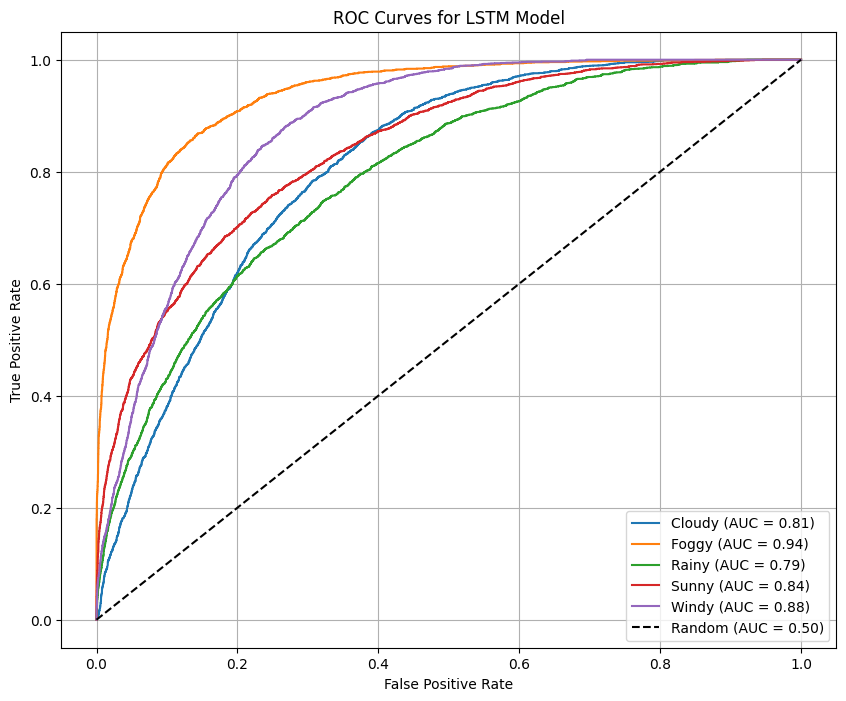

In [ ]:
import matplotlib.pyplot as plt

# Plot LSTM ROC Curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(lstm_fpr[class_name], lstm_tpr[class_name], label=f'{class_name} (AUC = {lstm_auc[class_name]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for LSTM Model')
plt.legend()
plt.grid(True)
plt.show()



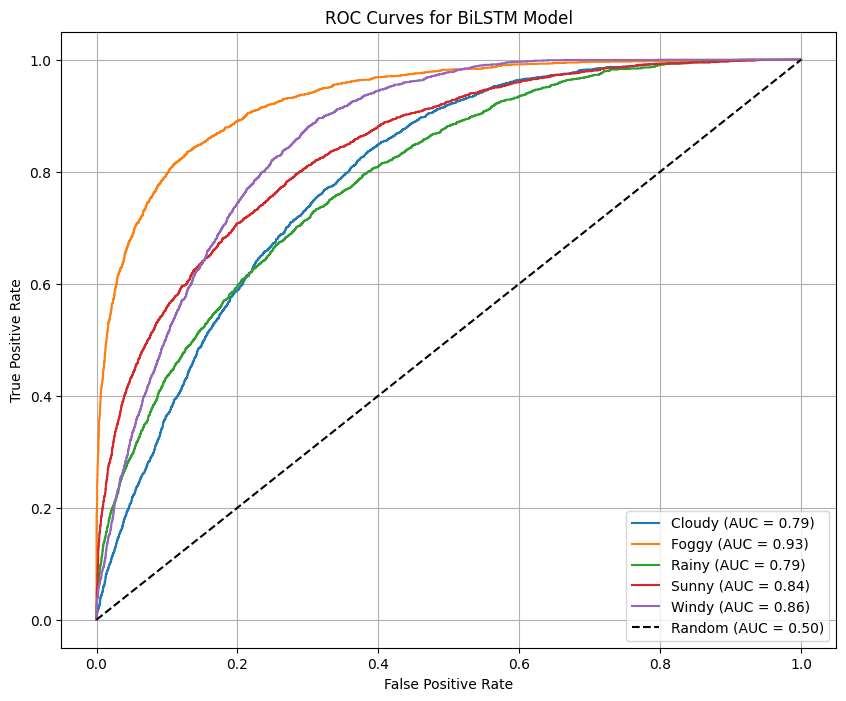

In [ ]:

# Plot BiLSTM ROC Curves
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(label_encoder.classes_):
    plt.plot(bilstm_fpr[class_name], bilstm_tpr[class_name], label=f'{class_name} (AUC = {bilstm_auc[class_name]:.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for BiLSTM Model')
plt.legend()
plt.grid(True)
plt.show()